In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings                         # warning메시지 무시
warnings.filterwarnings('ignore')
plt.rc("axes", unicode_minus = False)   # 음수부호 표시하도록 설정

In [ ]:
#1. 파일 로딩 및 확인

import pandas as pd
file_path = "/content/drive/MyDrive/Colab Notebooks/항공사 만족도/train.csv"
df = pd.read_csv(file_path)

df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target
0,1,Female,disloyal Customer,22,Business travel,Eco,1599,3,0,3,3,4,3,4,4,5,4,4,4,5,4,0,0.0,0
1,2,Female,Loyal Customer,37,Business travel,Business,2810,2,4,4,4,1,4,3,5,5,4,2,1,5,2,18,18.0,0
2,3,Male,Loyal Customer,46,Business travel,Business,2622,1,1,1,1,4,5,5,4,4,4,4,5,4,3,0,0.0,1
3,4,Female,disloyal Customer,24,Business travel,Eco,2348,3,3,3,3,3,3,3,3,2,4,5,3,4,3,10,2.0,0
4,5,Female,Loyal Customer,58,Business travel,Business,105,3,3,3,3,4,4,5,4,4,4,4,4,4,5,0,0.0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 3000 non-null   int64  
 1   Gender                             3000 non-null   object 
 2   Customer Type                      3000 non-null   object 
 3   Age                                3000 non-null   int64  
 4   Type of Travel                     3000 non-null   object 
 5   Class                              3000 non-null   object 
 6   Flight Distance                    3000 non-null   int64  
 7   Seat comfort                       3000 non-null   int64  
 8   Departure/Arrival time convenient  3000 non-null   int64  
 9   Food and drink                     3000 non-null   int64  
 10  Gate location                      3000 non-null   int64  
 11  Inflight wifi service              3000 non-null   int64

#데이터 확인 결과

In [ ]:
#0.Data type : Target(Binary) , Feature(0~5 int), 기타 Feature(int, Delay minutes / Distance / Age),  Object(Gender, Customer Type, Type of Travel, Class)

#1.Target은 0&1의 binary로 표현
#    1-1. 배운 내용 중 Logistic regression (활성함수 sigmoid)이 적합 할 것이다.  (딥러닝 사용시, 성능 향상에 있어 feature가 많은 데이터이므로 node 수 증가 방식이 적합할 것.)
#        1-1-1. 다중공선성 제거(by 상관계수 & pair plot)
#        1-1-2. 데이터 편중 여부 및 스케일 확인 (Data Histogram)

#2.Feature(0~5 int) =>null 값은 없음. 그러나, 0값이 존재하는데 이에 대한 처리 필요 할 것.  
#    2-1. 점수상 0값은 critical 할 것 같은데 3~4개 항목에 0점을 주었음에도 불구하고 최종 만족 응답인 경우가 있는 것으로 보아 null값 대신 입력된 것이 아닌가라는 가설 설정.
#        (일반적으로 고객만족도 조사는 1~5점의 리커트척도를 사용한다는 점 역시 생각해 볼 수 있다.)
#        (null 값이라면 어떤 값으로 대체할 것인가? 평균값,중앙값,최빈값 ->히스토그램으로 전체적인 편향 및 중간값,평균값 위치 확인해 보고 가장 영향을 적게 줄 수 있는 값을 찾아보자.(자전거 예시))

#3. 기타 Feature 값 (Delay minutes / Distance / Age)
#   3-1. Delay 시간의 경우 평가지표로서 반영 될것이기 때문에 0~5점의 리커트 척도로의 전환 필요 & Delay에서의 0은 만족도 척도의 5로 주는 것이 타당할 것이므로 반비례 양상임을 주의!  (=> 스케일 조절 후, 5개 구간으로 나누고 가장 유사한 feature를 찾아보자.)  
#   3-2. Distance의 경우 고객이 사전 인지하는 요소이기 때문에 평가지표로서 크게 반영되지는 않을 것. --> 단, 장거리 일수록 seat comfort 등의 요소가 더 크게 작용할 수는 있지 않을까? (=> heatmap으로 볼때 관련이 없음)
#   3-3. (Age) Box Plot으로 성별에 따른 target 분포 차이가 나는지 확인

#4. Object(Gender, Customer Type, Type of Travel, Class)
#   4.1 만족도 점수에 반영하는 것은 부적합하므로, 분석 그룹 설정 지표로 사용하여 그룹별 가중치 차이가 나타나는지 확인해 보자.
#        (Gender)count plot으로 성별에 따른 target 분포 차이가 나는지 확인
#        (Type of travel)count plot으로 성별에 따른 target 분포 차이가 나는지 확인
#        (Class) Business class 이용객들과 Economy 이용객들간의 중요하게 여기는 지표의 차이가 있지 않을까? --> 오렌지로 확인 결과 있음!
#        (Customer Type) 충성고객의 경우 비충성고객보다 만족도가 높을 것이다. (이를 반영 해야 하는가? 어떻게 반영 해야하는가?)

:::#1-1-1. 다중공선성 등을 확인하기 위한 사전 데이터 확인 작업

- 전체 pair plot을 그려 확인한 결과 특별한 경향성을 보이는 지표관계는 거의 없었다. 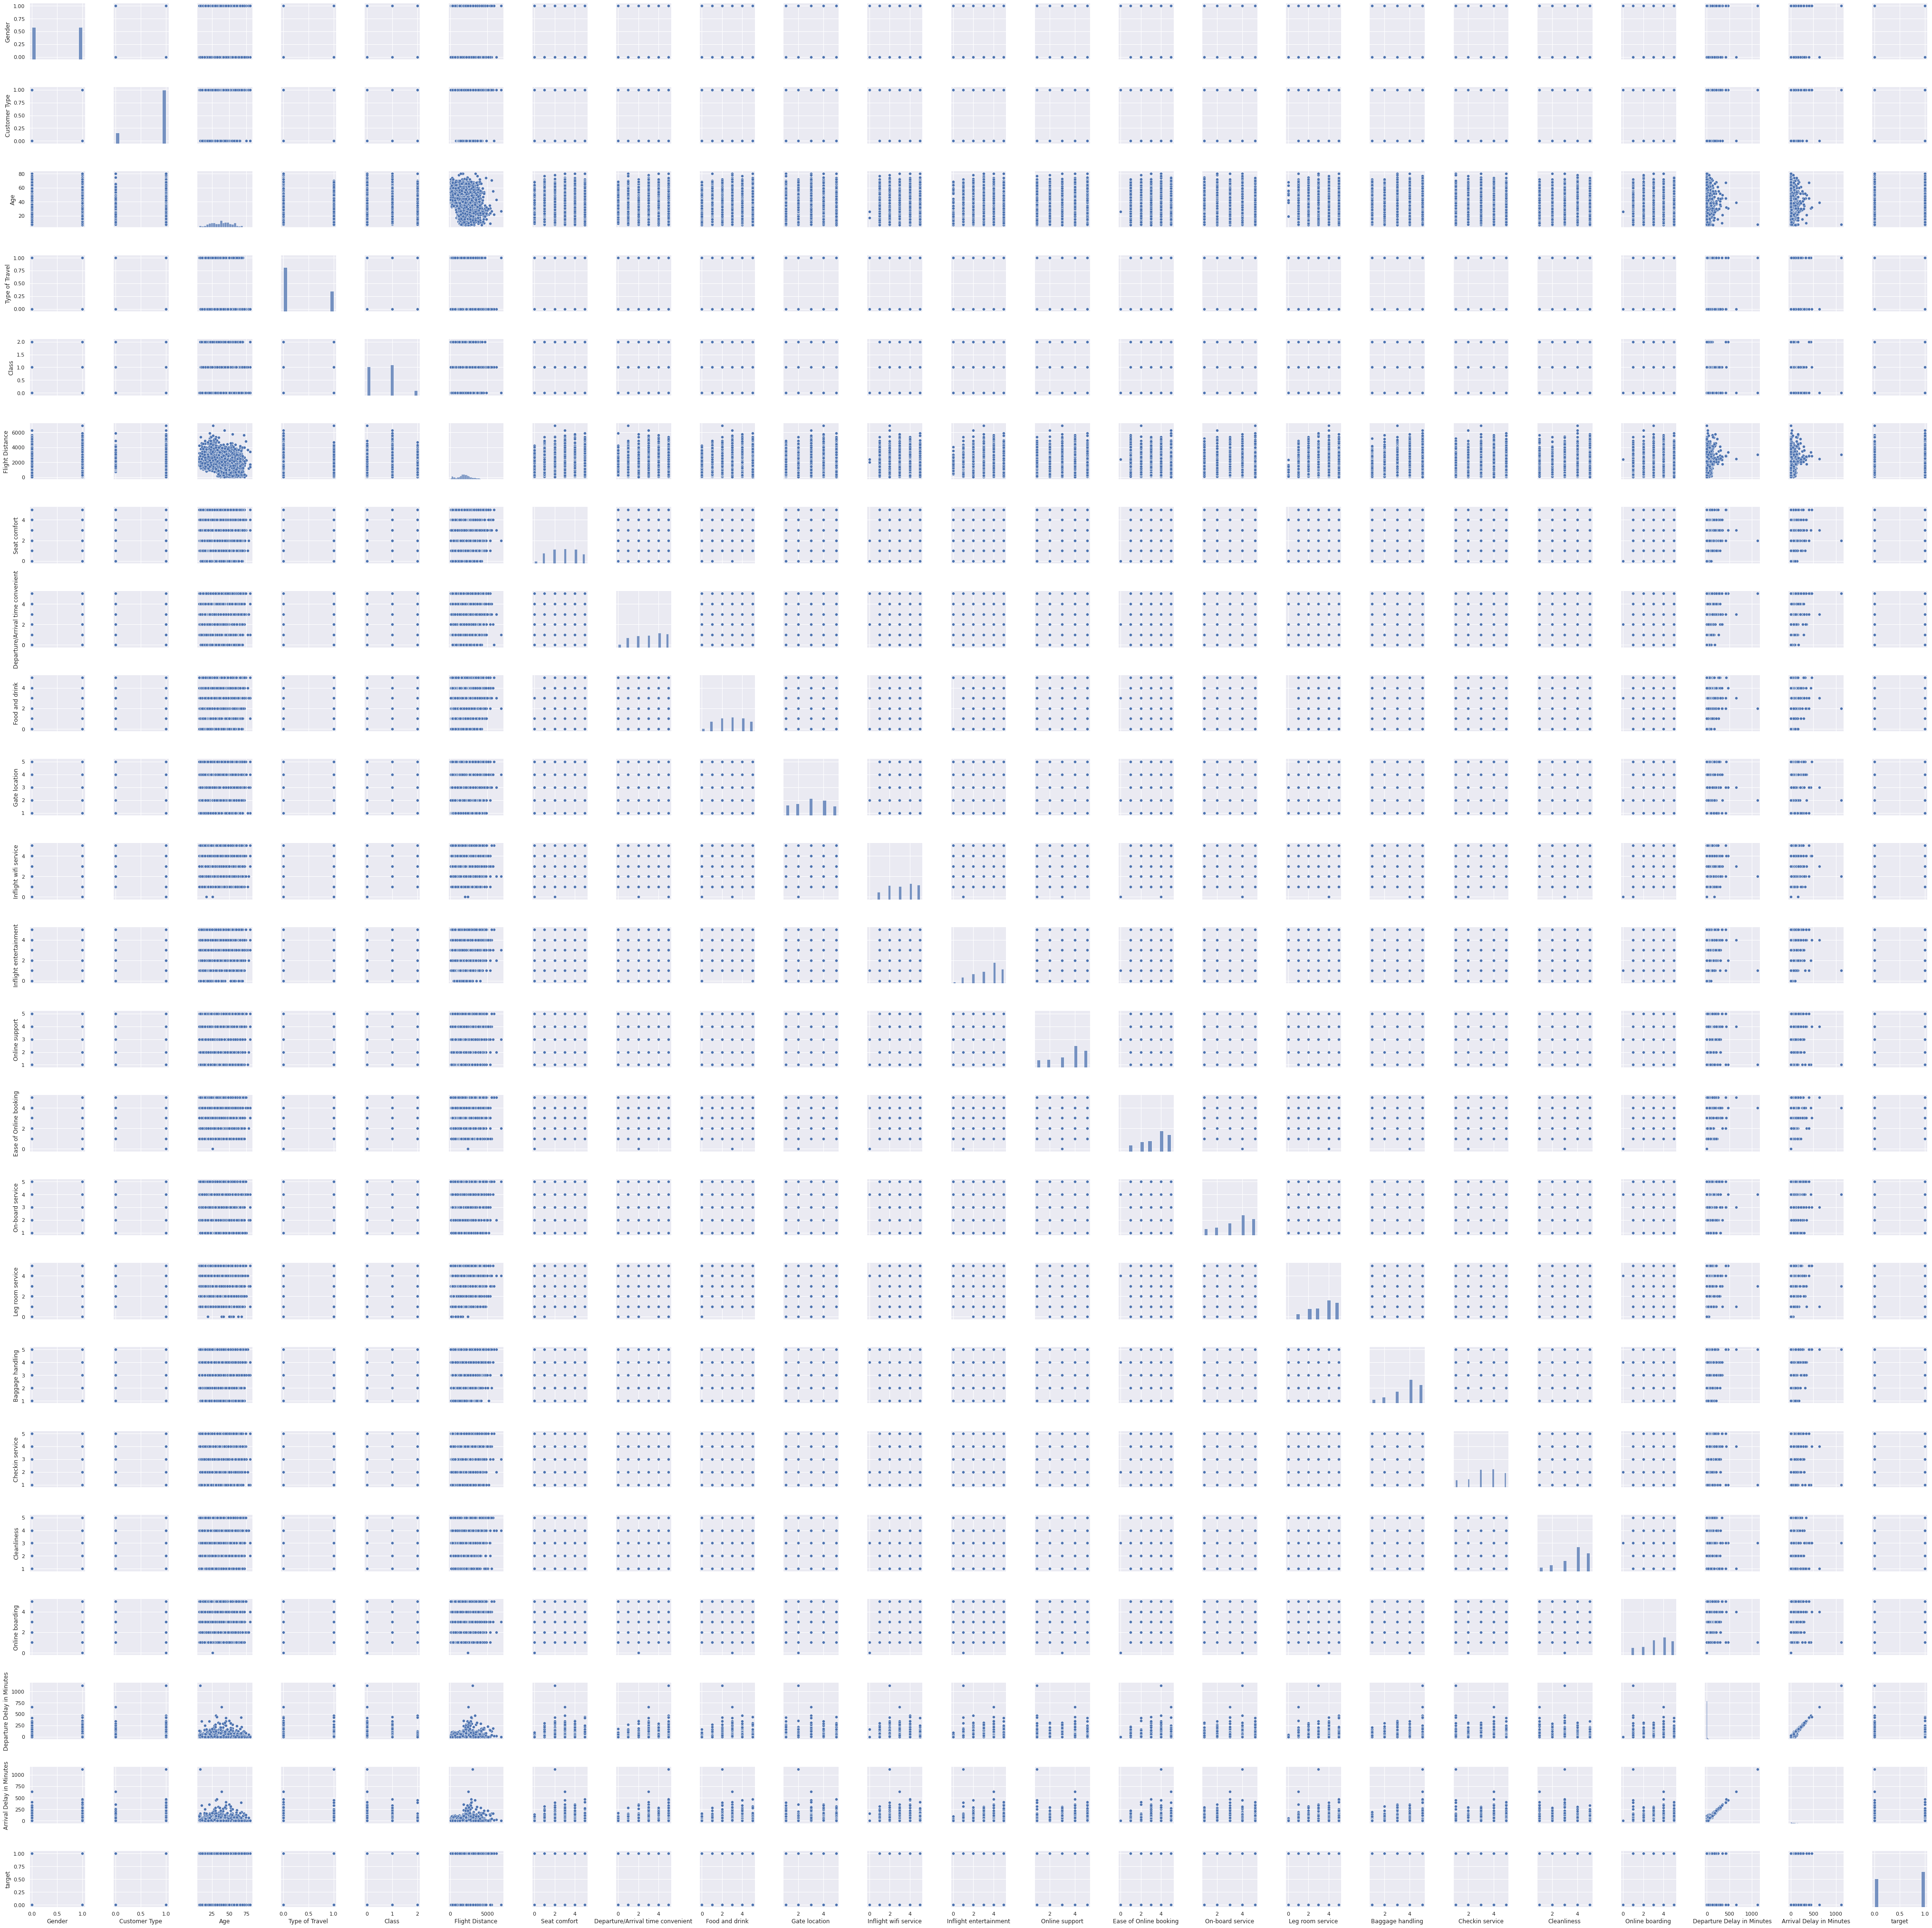

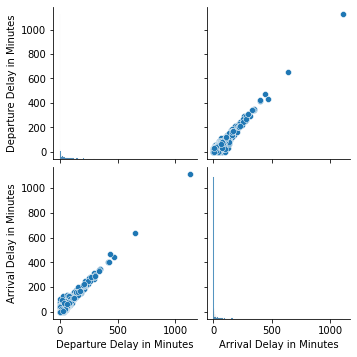

In [ ]:
delay_coloumns = ['Departure Delay in Minutes','Arrival Delay in Minutes']
sns.pairplot(df[delay_coloumns])
#유일하게 pair 관계가 명확히 보이는 항목: 출발지연 및 도착지연 => 둘 중 하나의 값만 변수로 취하기로 한다.

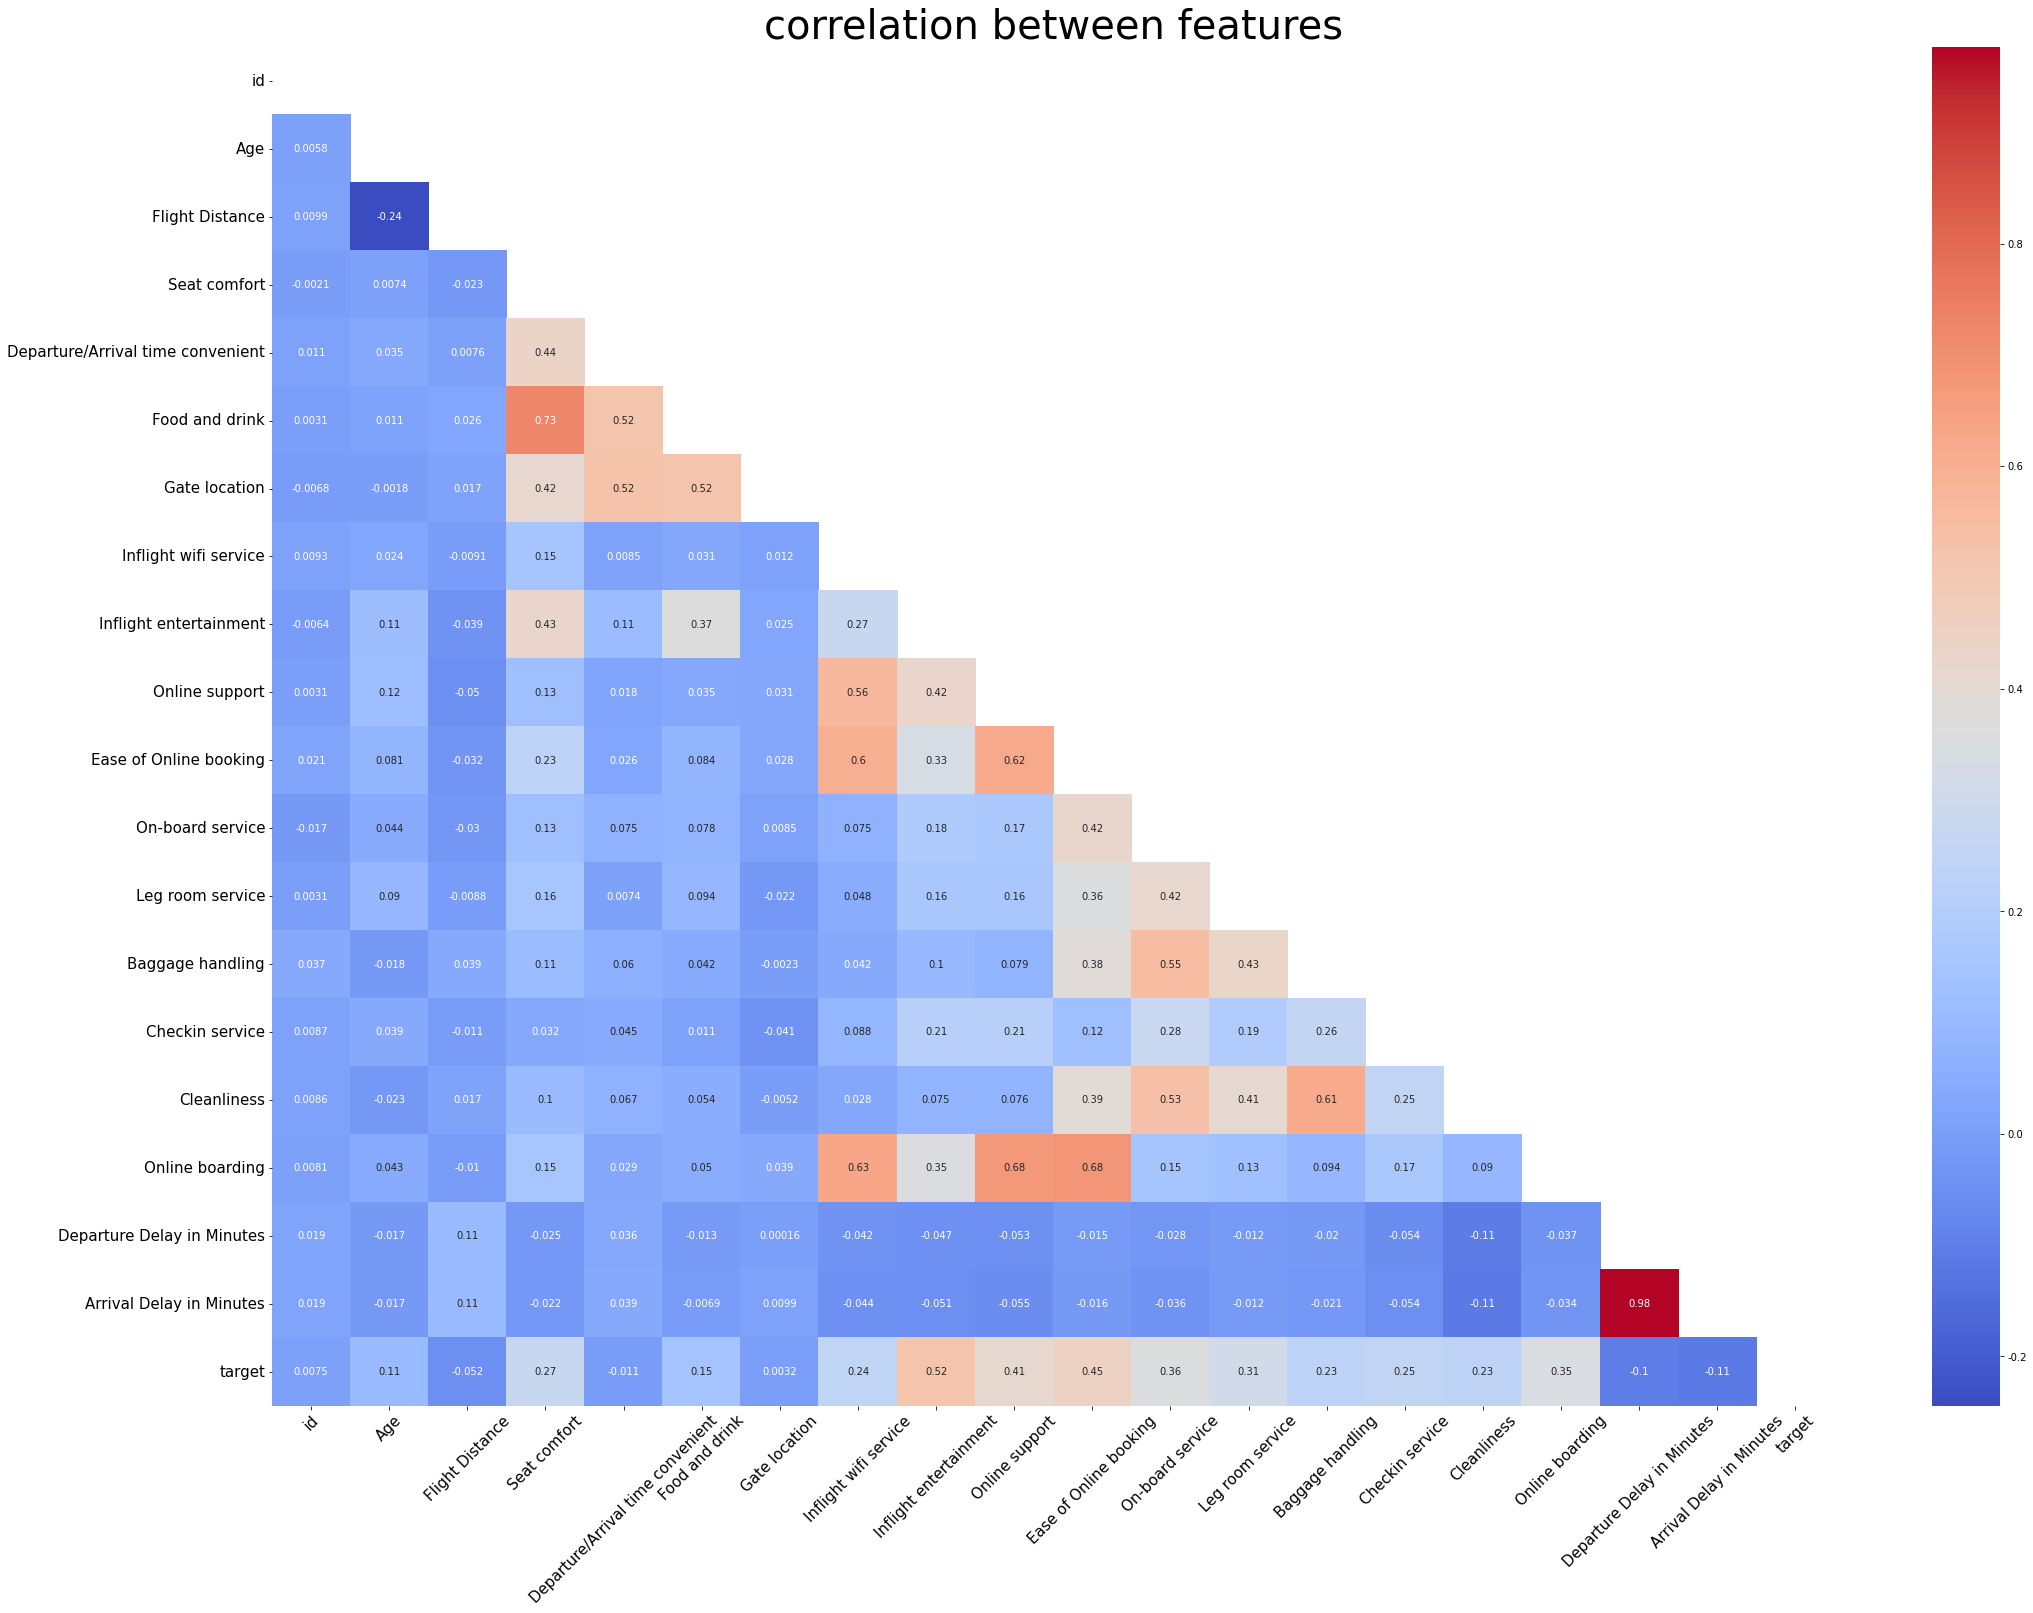

In [ ]:
#heat map으로 분석해보자
plt.figure(figsize=(35,25))

heat_table = df.corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, mask = mask, cmap='coolwarm')
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features', fontsize=40)
plt.show()

#Food & seat comfort  // Delay&Delay // Online support/online Booking/ online boarding (0.6이상) ==> 하나의 지표만 사용하자! 
#해석
#음식 & 좌석 : ??  -->0값이 있을 경우 다른 지표의 값으로 대체해도 되지 않을까?
#Delay&Delay : 지연은 당연히 연관될 수 밖에
#Online support/online Booking/ online boarding : Online이라는 유사 항목이므로 전반적으로 상관도가 있을 것. -->0값이 있을 경우 다른 지표의 값으로 대체해도 되지 않을까?

##1-1-2. 데이터 편중 여부 및 스케일 확인 

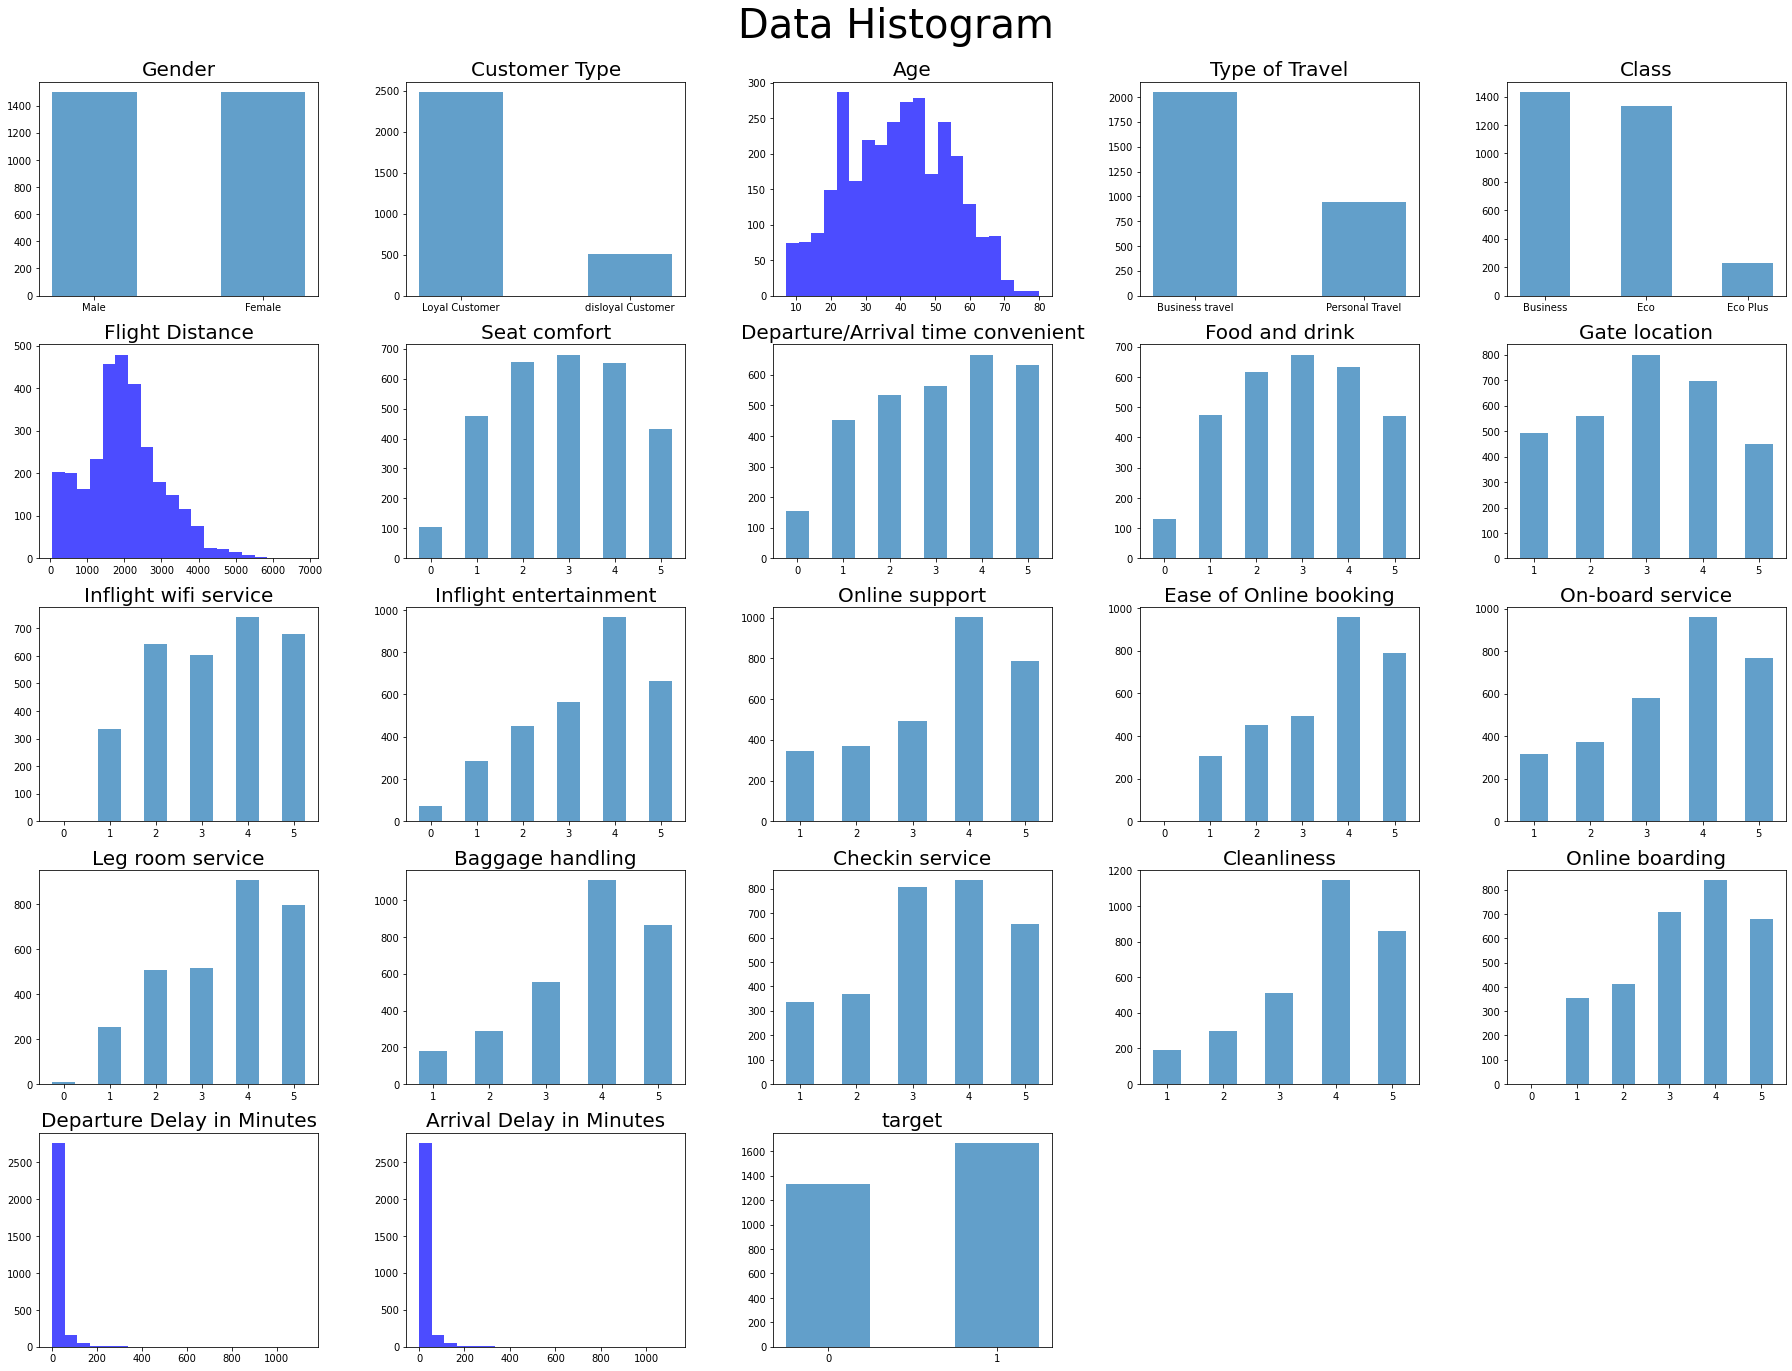

In [ ]:
from IPython.core.display import display_pdf
plt.figure(figsize=(25, 20))
plt.suptitle("Data Histogram", fontsize = 40)

# id는 제외하고 시각화
cols = df.columns
for i in range(len(cols)):
    plt.subplot(5, 5, i+1)
    plt.title(cols[i], fontsize=20) 
    if len(df[cols[i]].unique()) > 20: 
        plt.hist(df[cols[i]], bins=20, color='b', alpha=0.7) 
        
    else: 
        temp = df[cols[i]].value_counts() 
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


'''
#해석
1. Customer Type의 표본수 차이가 1:5 정도로 크게 나타남.
2. Type of Travel의 표본수 차이는 약 1:2.
3. Eco Plus의 표본값이 Business 및 Eco 값에 비해 6배이상 적다.
4. Delay 시간 데이터는 좌편향 되어있어, 1~5점 표준화 시 적절한 조치가 필요할 것.
5. Flight Distance 도 약간 좌편향.

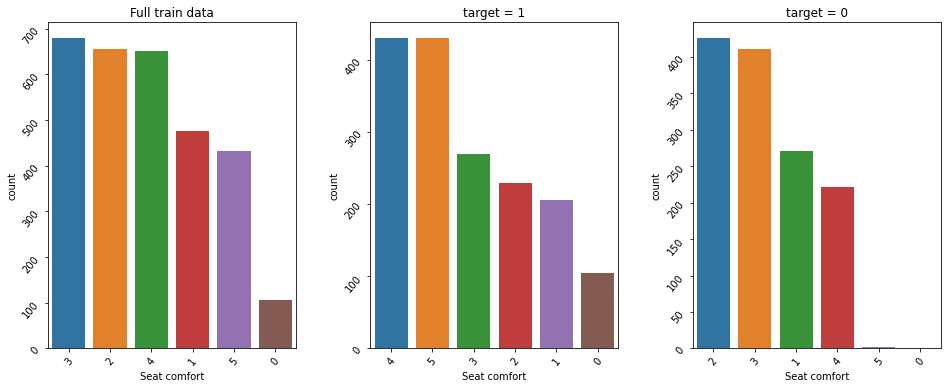

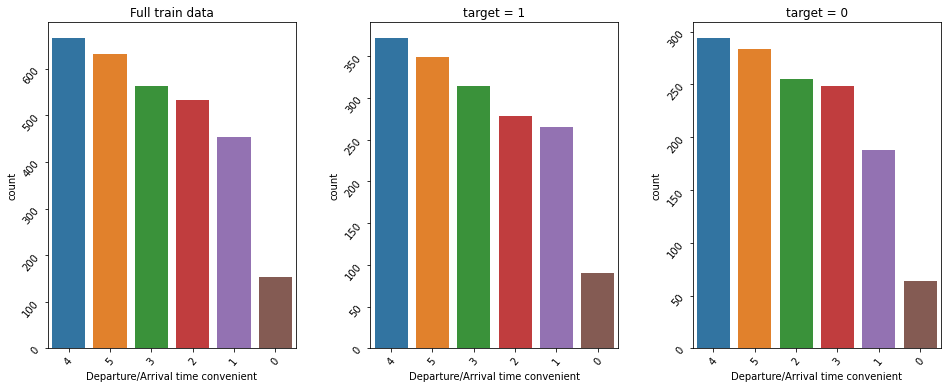

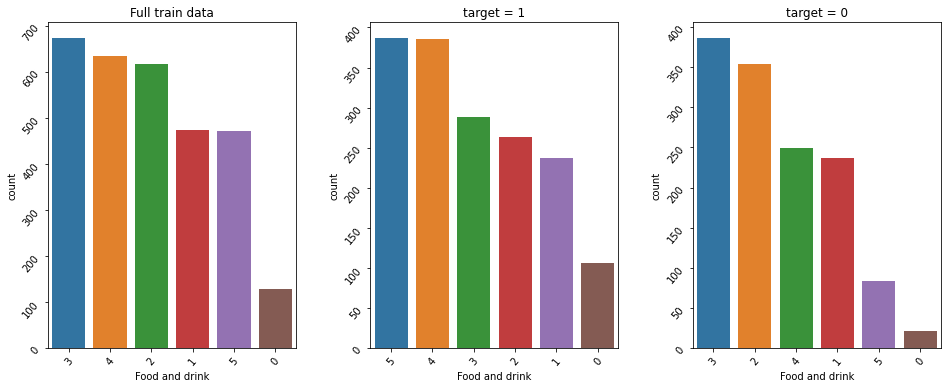

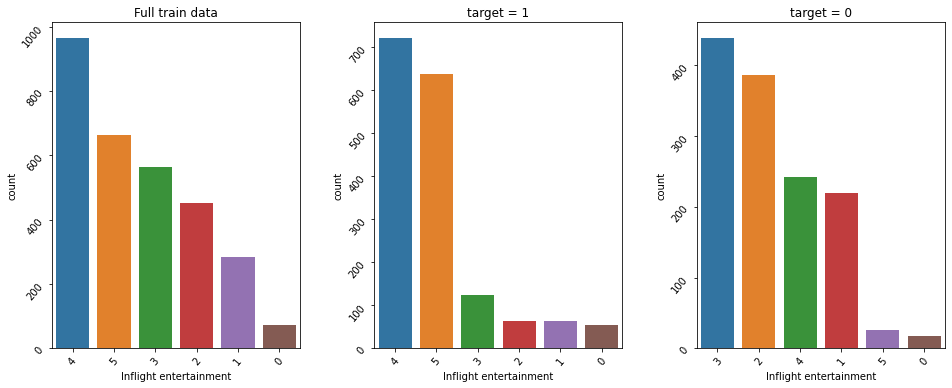

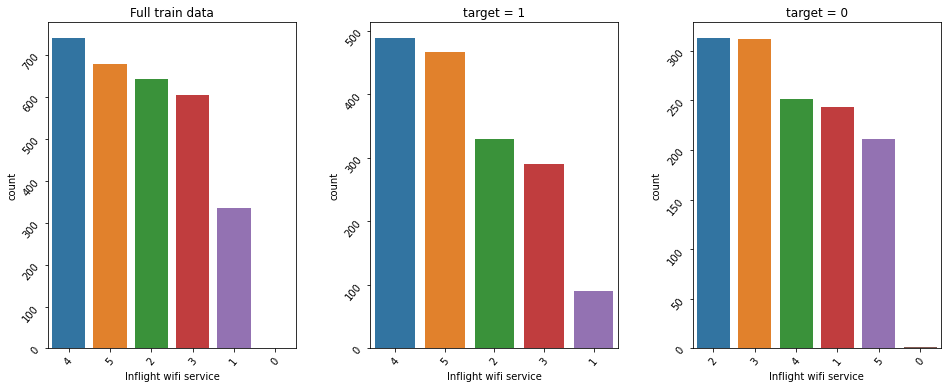

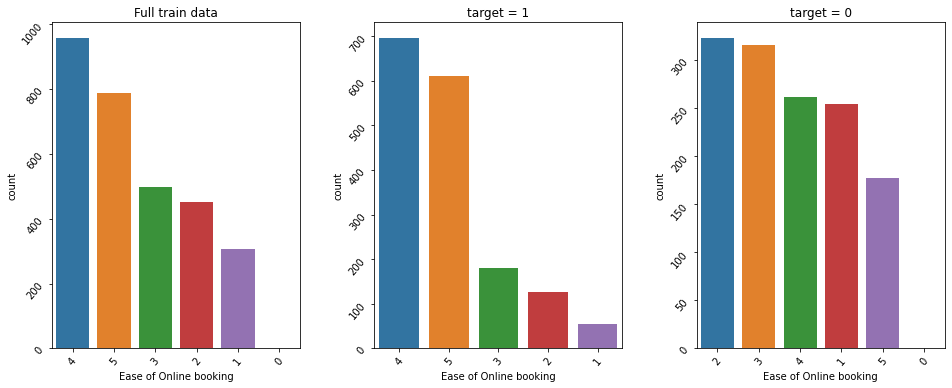

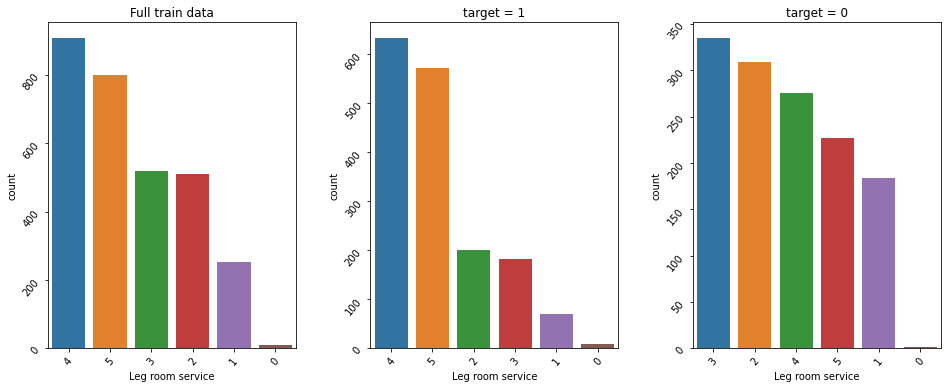

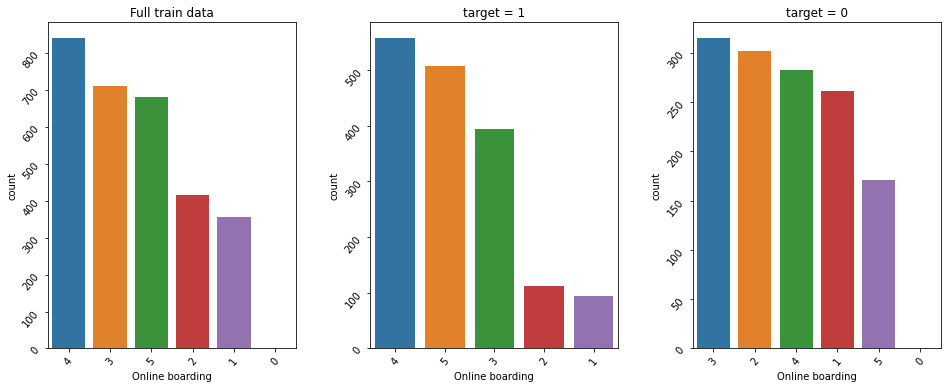

'\n해석\n오히려 0값을 갖는 고객에서 target 값이 1이 나오는 것으로 보아 큰 연관성은 없는 것으로 보인다.'

In [ ]:
train = df
train_1 = df[df['target']==1]
train_0 = df[df['target']==0]

def count_plot(column):
    f, ax = plt.subplots(1, 3, figsize=(16, 6))
    sns.countplot(x = column,
                data = train,
                ax = ax[0],
                order = train[column].value_counts().index
                )    
    plt.ylim[(0,1000)]
    ax[0].set_title('Full train data')
    ax[0].set_ylabel('count')
    ax[0].tick_params(rotation=50)


    sns.countplot(x = column, data = train_1,
                ax = ax[1],
                order = train_1[column].value_counts().index)   
    ax[1].set_title('target = 1')
    ax[1].set_ylabel('count')
    ax[1].tick_params(rotation=50)

    sns.countplot(x = column,
                data = train_0,
                ax = ax[2],
                order = train_0[column].value_counts().index)
    ax[2].set_title('target = 0')
    ax[2].set_ylabel('count')
    ax[2].tick_params(rotation=50)

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

count_plot('Seat comfort')
count_plot('Departure/Arrival time convenient')
count_plot('Food and drink')
count_plot('Inflight entertainment')
count_plot('Inflight wifi service')
count_plot('Ease of Online booking')
count_plot('Leg room service')
count_plot('Online boarding')



'''
해석
오히려  target 값이 1인 항목에서 0값을 갖는 표본이 더 많은 것으로 보아 실제 0값이 아닌 null값을 대체하였음을 추론 할 수 있다.'''